# HDF Reference Recipe for CMIP6

This example illustrates how to create a Reference Recipe using CMIP6 data.
This recipe does not actually copy the original source data.
Instead, it generates metadata files which reference and index the original data, allowing it to be accessed more efficiently.
For more background, see [this blog post](https://medium.com/pangeo/fake-it-until-you-make-it-reading-goes-netcdf4-data-on-aws-s3-as-zarr-for-rapid-data-access-61e33f8fe685).

As the input for this recipe, we will use some CMIP6 NetCDF4 files provided by ESGF and stored in Amazon S3 ([CMIP6 AWS Open Data Page](https://registry.opendata.aws/cmip6/)).
Many CMIP6 simulations spread their outputs over many HDF5/ NetCDF4 files, in order to limit the individual file size.
This can be inconvenient for analysis.
In this recipe, we will see how to virtually concatenate many HDF5 files into one big virtual Zarr dataset.

## Define the FilePattern

Let's pick a random dataset: ocean model output from the GFDL ocean model from the [OMIP](https://www.wcrp-climate.org/modelling-wgcm-mip-catalogue/cmip6-endorsed-mips-article/1063-modelling-cmip6-omip) experiments.

In [1]:
import s3fs
fs = s3fs.S3FileSystem(anon=True)
base_path = 's3://esgf-world/CMIP6/OMIP/NOAA-GFDL/GFDL-CM4/omip1/r1i1p1f1/Omon/thetao/gr/v20180701/'
all_paths = fs.ls(base_path)
all_paths

['esgf-world/CMIP6/OMIP/NOAA-GFDL/GFDL-CM4/omip1/r1i1p1f1/Omon/thetao/gr/v20180701/thetao_Omon_GFDL-CM4_omip1_r1i1p1f1_gr_170801-172712.nc',
 'esgf-world/CMIP6/OMIP/NOAA-GFDL/GFDL-CM4/omip1/r1i1p1f1/Omon/thetao/gr/v20180701/thetao_Omon_GFDL-CM4_omip1_r1i1p1f1_gr_172801-174712.nc']

We see there are 15 individual NetCDF files. Let's time how long it takes to open and display one of them using Xarray.

```{note}
The argument `decode_coords='all'` helps Xarray promote all of the `_bnds` variables to coordinates (rather than data variables).
```

In [ ]:
import xarray as xr

In [ ]:
%%time
ds_orig = xr.open_dataset(fs.open(all_paths[0]), engine='h5netcdf', chunks={}, decode_coords='all')
ds_orig

It took ~30 seconds to open this one dataset. So it would take 7-8 minutes for us to open every file. This would be annoyingly slow.

As a first step in our recipe, we create a `File Pattern <../../recipe_user_guide/file_patterns>` to represent the input files.
In this case, since we already have a list of inputs, we just use the `pattern_from_file_sequence` convenience function.

In [2]:
from pangeo_forge_recipes.patterns import pattern_from_file_sequence
pattern = pattern_from_file_sequence(['s3://' + path for path in all_paths], 'time')
pattern

<FilePattern {'time': 2}>

## Write the Recipe

Once we have our `FilePattern`, describing our input file paths, we can construct out `beam` pipeline. A beam pipeline is a chained together list of (Apache Beam transformations)[https://beam.apache.org/documentation/programming-guide/#transforms].


<!-- The only custom options we need are to specify that we'll be accessing the source files anonymously and to use `decode_coords='all'` when opening them. -->

### Specify where our target data should be written


In [24]:
import os
from tempfile import TemporaryDirectory
td = TemporaryDirectory()
target_root = td.name
store_name = "output.json"
target_store = os.path.join(target_root, store_name)

## Construct a Pipeline

In [25]:
import apache_beam as beam
from pangeo_forge_recipes.transforms import OpenURLWithFSSpec, OpenWithXarray, StoreToZarr, OpenWithKerchunk, DropKeys, CombineReferences, WriteCombinedReference

store_name = "cmip6_reference"
reference_file_type = "json"
transforms = (
        beam.Create(pattern.items())
        | OpenURLWithFSSpec(open_kwargs={'anon':True})
        | OpenWithKerchunk(file_type=pattern.file_type)
        | DropKeys()
        | CombineReferences(concat_dims=["time"], 
                            identical_dims=["lat", "lat_bnds", "lon", "lon_bnds", "lev_bnds", "lev"],
                            mzz_kwargs = {"remote_protocol": "s3"} )
        | WriteCombinedReference(
            target_root=target_root,
            store_name=store_name,
            reference_file_type=reference_file_type,
        )
    )

## Execute the Recipe

In [26]:
with beam.Pipeline() as p:
    p | transforms

## Examine the Result



In [27]:
import fsspec 
import xarray as xr
full_path = os.path.join(target_root, store_name, f"target.{reference_file_type}")
mapper = fsspec.get_mapper("reference://", fo=full_path, remote_protocol="s3",)
ds = xr.open_dataset(mapper, engine="zarr", decode_coords='all', backend_kwargs={"consolidated": False})


/var/folders/mb/7d7yq_4j2qgdfm_j3j4tsyl40000gn/T/ipykernel_4510/2772145341.py:5: UserWarning: Variable(s) referenced in cell_measures not in variables: ['areacello', 'volcello']
  ds = xr.open_dataset(mapper, engine="zarr", decode_coords='all', backend_kwargs={"consolidated": False})


In [28]:
ds

<xarray.Dataset>
Dimensions:    (lat: 180, bnds: 2, lev: 35, lon: 360, time: 480)
Coordinates:
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    lat_bnds   (lat, bnds) float64 ...
  * lev        (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
    lev_bnds   (lev, bnds) float64 ...
  * lon        (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
    lon_bnds   (lon, bnds) float64 ...
  * time       (time) object 1708-01-16 12:00:00 ... 1747-12-16 12:00:00
    time_bnds  (time, bnds) object ...
Dimensions without coordinates: bnds
Data variables:
    thetao     (time, lev, lat, lon) float32 ...
Attributes: (12/44)
    Conventions:           CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:           OMIP
    branch_method:         none provided
    branch_time_in_child:  0.0
    comment:               Experiment name = OM4p25_IAF_BLING_csf_rerun\nFor ...
    contact:               gfdl.climate.model.info@noaa.gov
    ...                    ...
    table_id:              Omon
    title:                 NOAA GFDL GFDL-CM4 model output prepared for CMIP6...
    tracking_id:           hdl:21.14100/97e4edf3-22e7-4e5f-831a-f2a671b7094f
    variable_id:           thetao
    variant_info:          N/A
    variant_label:         r1i1p1f1

## Make a Map

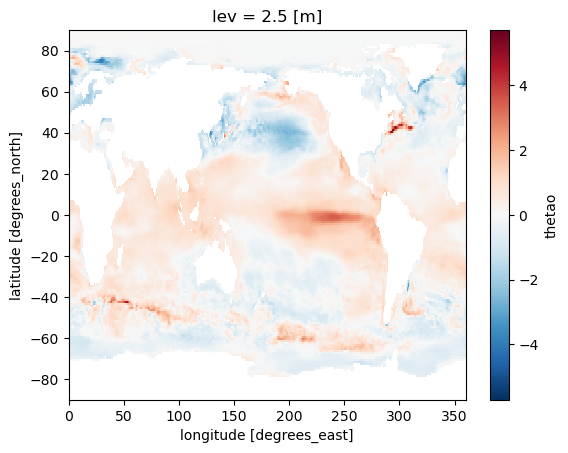

In [29]:
ds_ann = ds.resample(time='A').mean()
sst_diff = ds_ann.thetao.isel(time=-1, lev=0) - ds_ann.thetao.isel(time=0, lev=0)
sst_diff.plot()